In [56]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from rnn import RNNNet
from dataset import StimuliDataset
import matplotlib.pyplot as plt

In [57]:



color_red = "#ffb55a"
color_blue = "#fd7f6f"
color_purple = "#ffee65"
color_yellow = "#8bd3c7"
color_orange = "#bd7ebe"
color_green = "#7eb0d5"

'''

color_red = "#0000b3"
color_blue = "#0020ff"
color_purple = "#0060ff"
color_yellow = "#009fff"
color_orange = "#00bfff"
color_green = "#00ffff"
'''


'\n\ncolor_red = "#0000b3"\ncolor_blue = "#0020ff"\ncolor_purple = "#0060ff"\ncolor_yellow = "#009fff"\ncolor_orange = "#00bfff"\ncolor_green = "#00ffff"\n'

In [58]:
#loads the model
hidden_size = 128
input_size = 13
output_size = 6
dt = 0.1
tau = 100
batch_size = 1
model_path = './model.pt'
num_trials = 500
net = RNNNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=dt, tau=tau)
net.load_state_dict(torch.load(model_path))
# Check if a GPU is available
device = torch.device("cpu")

# Move the network to the device
net = net.to(device)

dataset = StimuliDataset(num_trials)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [59]:
stimulus_activity_dict = {}
decision_activity_dict = {}
attended_info = {} 
diff_object={}  #only records attended trials
for i, (stimulus, labels) in enumerate(dataloader):
            labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)
            stimuli = np.stack([stimulus] * 3, axis=1)
            stop_cue = np.zeros((batch_size,1,input_size))
            inputs  = np.concatenate((stimuli, stop_cue), axis=1)
            attended_info[i] = inputs[0][0][-1] #records the trial-specific attentional cue                
            inputs = torch.from_numpy(inputs).float().to(device)
            labels = labels.float().to(device)  # Convert labels to long and move to device

            output, rnn_activity = net(inputs.permute(1, 0, 2))
            if (attended_info[i]==0):
                    diff_object[i] = np.argmax(inputs[0][0][:6]).item()
            rnn_activity = rnn_activity[:, 0, :].detach().numpy()
            stimulus_activity_dict[i] = rnn_activity[:3][:]
            decision_activity_dict[i] = np.expand_dims(rnn_activity[-1][:], axis=0)
print("finished")
#print(len(stimulus_activity_dict)) #500*(3,128)

/tmp/ipykernel_31510/3098808785.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)


finished


In [60]:
attended_trials_stimulus = []
attended_trials_decision = []
unattended_trials_stimulus = []
unattended_trials_decision = []
for i in range(len(attended_info)):
        if (attended_info[i] > 0):
                attended_trials_stimulus.append(stimulus_activity_dict[i])
                attended_trials_decision.append(decision_activity_dict[i])
        else:
                unattended_trials_stimulus.append(stimulus_activity_dict[i])
                unattended_trials_decision.append(decision_activity_dict[i])
                
                
attended_trials_num = len(attended_trials_stimulus)
unattended_trials_num = len(unattended_trials_stimulus)

print(unattended_trials_num)
print(attended_trials_stimulus[0].shape)
attended_trials_stimulus = np.concatenate(list(attended_trials_stimulus[i] for i in range(attended_trials_num)), axis=0)
attended_trials_decision = np.concatenate(list(attended_trials_decision[i] for i in range(attended_trials_num)), axis=0)
unattended_trials_stimulus = np.concatenate(list(unattended_trials_stimulus[i] for i in range(unattended_trials_num)), axis=0)
unattended_trials_decision = np.concatenate(list(unattended_trials_decision[i] for i in range(unattended_trials_num)), axis=0)

print(unattended_trials_stimulus.shape)

267
(3, 128)
(801, 128)


In [61]:
#define color
color_list = []
for key, value in diff_object.items():
    if (value == 0):
        color = color_red
    if (value == 1):
        color = color_blue
    if (value == 2):
        color = color_purple 
    if (value == 3):
        color = color_yellow 
    if (value == 4):
        color = color_orange 
    if (value == 5):
        color = color_green 
    color_list.append(color)
    color_list.append(color)
    color_list.append(color)
print(len(color_list))

801


In [62]:
from sklearn import datasets, manifold
from matplotlib import ticker

def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(5, 5), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

    
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    


In [12]:
print(unattended_trials_stimulus.shape)

(756, 128)


(801, 128)


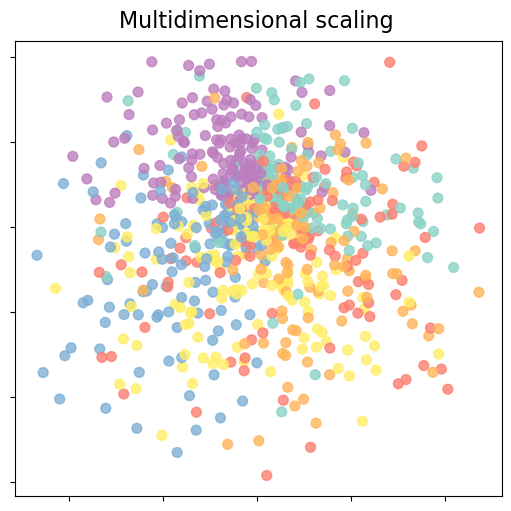

In [64]:


md_scaling = manifold.MDS(
    max_iter=200,
    n_init=6,
    random_state=0,
    normalized_stress=False,
)

print(unattended_trials_stimulus.shape)

S_scaling = md_scaling.fit_transform(unattended_trials_stimulus)

plot_2d(S_scaling, color_list, "Multidimensional scaling")


In [65]:
print(S_scaling.shape)

(801, 2)


In [66]:
#calculates mean and variance
group_0=[]
group_1=[]
group_2=[]
group_3=[]
group_4=[]
group_5=[]
for i,color in enumerate(color_list):
    if color == color_red:
        group_0.append(S_scaling[i])
    if color == color_blue:
        group_1.append(S_scaling[i])
    if color == color_purple:
        group_2.append(S_scaling[i])
    if color == color_yellow:
        group_3.append(S_scaling[i])
    if color == color_orange:
        group_4.append(S_scaling[i])
    if color == color_green:
        group_5.append(S_scaling[i])
#S_scaling.mean(0)
matrices = []
matrices.append(np.stack(group_0)) #(117,2)
matrices.append(np.stack(group_1))
matrices.append(np.stack(group_2))
matrices.append(np.stack(group_3))
matrices.append(np.stack(group_4))
matrices.append(np.stack(group_5))

mean = [0] * 6
covariance_matrices = []
for i in range(6):
    mean[i] = matrices[i].mean(0)
    covariance_matrices.append(np.cov(matrices[i], rowvar=False)
)


In [45]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

data = {}
data['Group'] = []
data['Dependent1'] = []
data['Dependent2'] = []

for i in range(len(S_scaling)):
    color = color_list[i]
    if color == color_red:
        data['Group'].append(0)
    elif color == color_blue:
        data['Group'].append(1)
    elif color == color_purple:
        data['Group'].append(2)
    elif color == color_yellow:
        data['Group'].append(3)
    elif color == color_orange:
        data['Group'].append(4)
    elif color == color_green:
        data['Group'].append(5)
    data['Dependent1'].append(float(S_scaling[i][0]))
    data['Dependent2'].append(float(S_scaling[i][1]))

df = pd.DataFrame(data)

# Step 2: Create a MANOVA object
groups = df['Group']  # Grouping variable
dependent_vars = df[['Dependent1', 'Dependent2']]  # Dependent variables

manova = MANOVA(dependent_vars, groups)

# Step 3: Access the test results
result = manova.mv_test()

# Step 4: Print or analyze the results as needed
print(result)




                  Multivariate linear model
                                                             
-------------------------------------------------------------
           x0           Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9373 2.0000 754.0000 25.2352 0.0000
         Pillai's trace 0.0627 2.0000 754.0000 25.2352 0.0000
 Hotelling-Lawley trace 0.0669 2.0000 754.0000 25.2352 0.0000
    Roy's greatest root 0.0669 2.0000 754.0000 25.2352 0.0000



In [67]:
tukey = pairwise_tukeyhsd(endog=df['Dependent1'],
                          groups=df['Group'],
                          alpha=0.05)
print(tukey)

tukey = pairwise_tukeyhsd(endog=df['Dependent2'],
                          groups=df['Group'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.0767 0.0003  0.0253  0.1282   True
     0      2   0.2695   -0.0  0.2175  0.3215   True
     0      3   0.1763   -0.0  0.1243  0.2283   True
     0      4   0.1494   -0.0  0.0984  0.2003   True
     0      5   0.2567   -0.0  0.2024   0.311   True
     1      2   0.1928   -0.0   0.143  0.2426   True
     1      3   0.0996    0.0  0.0498  0.1494   True
     1      4   0.0727 0.0003   0.024  0.1214   True
     1      5     0.18   -0.0  0.1278  0.2322   True
     2      3  -0.0932    0.0 -0.1436 -0.0429   True
     2      4  -0.1201    0.0 -0.1694 -0.0709   True
     2      5  -0.0128 0.9828 -0.0655    0.04  False
     3      4  -0.0269 0.6249 -0.0762  0.0224  False
     3      5   0.0804 0.0002  0.0277  0.1332   True
     4      5   0.1073    0.0  0.0556  0.1591   True
----------------------------------------------

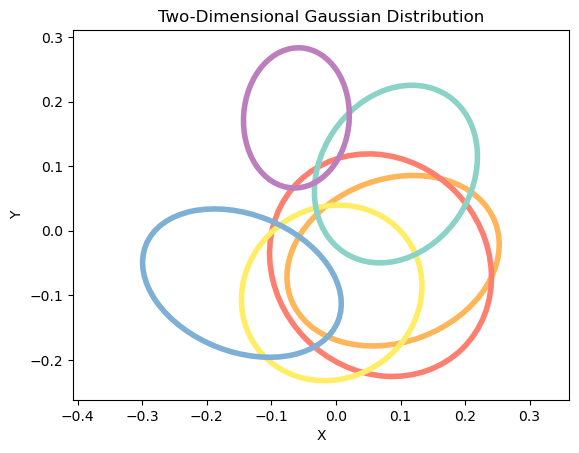

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_gaussian_ellipse(mean, covariance, std_dev=1.0, linewidth=1, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eig_vals, eig_vecs = np.linalg.eigh(covariance)

    # Calculate the angle of rotation for the ellipse
    angle = np.degrees(np.arctan2(*eig_vecs[:, 0][::-1]))

    # Create the ellipse with the 'fill' parameter set to False
    ellipse = Ellipse(xy=mean, width=2 * std_dev * np.sqrt(eig_vals[1]),
                      height=2 * std_dev * np.sqrt(eig_vals[0]), angle=angle, fill=False, linewidth=linewidth, **kwargs)

    # Add the ellipse to the plot
    ax.add_patch(ellipse)

    return ax


# Plot the Gaussian ellipse with one standard deviation
plot_gaussian_ellipse(mean[0], covariance_matrices[0], std_dev=1.0, ax=plt.gca(), linewidth=4, edgecolor = color_red)
plot_gaussian_ellipse(mean[1], covariance_matrices[1], std_dev=1.0, ax=plt.gca(), linewidth=4, edgecolor = color_blue)
plot_gaussian_ellipse(mean[2], covariance_matrices[2], std_dev=1.0, ax=plt.gca(), linewidth=4, edgecolor = color_purple)
plot_gaussian_ellipse(mean[3], covariance_matrices[3], std_dev=1.0, ax=plt.gca(), linewidth=4, edgecolor = color_yellow)
plot_gaussian_ellipse(mean[4], covariance_matrices[4], std_dev=1.0, ax=plt.gca(), linewidth=4, edgecolor = color_orange)
plot_gaussian_ellipse(mean[5], covariance_matrices[5], std_dev=1.0, ax=plt.gca(), linewidth=4, edgecolor = color_green)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Two-Dimensional Gaussian Distribution')

plt.axis('equal')
plt.show()


In [52]:
print(mean[0].shape)

(2,)


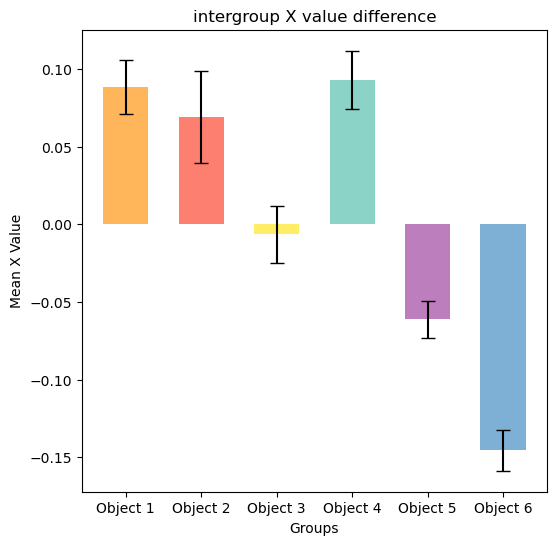

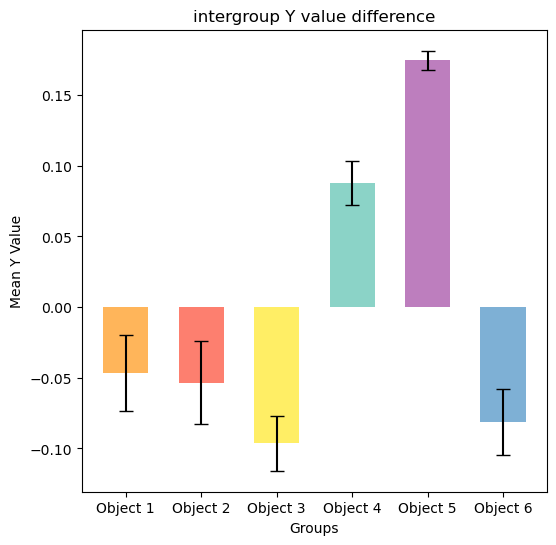

In [79]:
import numpy as np
import matplotlib.pyplot as plt



# Step 1: Calculate mean and variance for each group along x and y dimensions
mean_x = [np.mean(matrix[:, 0]) for matrix in matrices]
mean_y = [np.mean(matrix[:, 1]) for matrix in matrices]

var_x = [np.var(matrix[:, 0]) for matrix in matrices]
var_y = [np.var(matrix[:, 1]) for matrix in matrices]

# Step 2: Create bar plots with error bars
group_names = ['Object 1', 'Object 2', 'Object 3', 'Object 4', 'Object 5', 'Object 6']
colors = [color_red, color_blue, color_purple, color_yellow, color_orange, color_green]

# For the x-axis
plt.figure(figsize=(6, 6))
plt.bar(group_names, mean_x, yerr=var_x, capsize=5,color = colors,width=0.6)
plt.xlabel('Groups')
plt.ylabel('Mean X Value')
plt.title('intergroup X value difference')
plt.show()

# For the y-axis
plt.figure(figsize=(6, 6))
plt.bar(group_names, mean_y, yerr=var_y, capsize=5,color=colors,width=0.6)
plt.xlabel('Groups')
plt.ylabel('Mean Y Value')
plt.title('intergroup Y value difference')
plt.show()
